<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/ANF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning and spatail modeling using raster_tools
Author John Hogland 3/29/2022

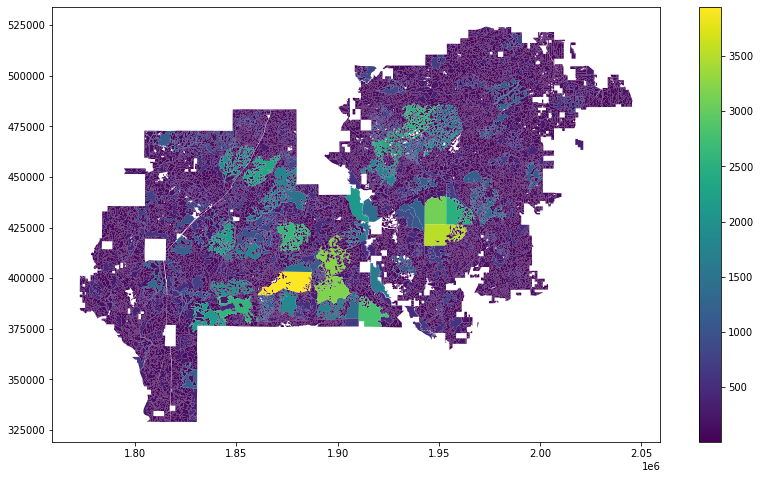

In this example we will use the stands of Apalachicola National Forest (ANF) and raster_tools to create spatial metrics, subset data into a training and validation dataset, create a predictive model, evaluate our model, and apply that model to the population of stands.  

## Installing raster_tools and update libraries

In [1]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade folium
!pip install raster_tools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=5ef31bad334a4b50f294bf620da0f798363e71c3b0144038f03bf7bf8df06663
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2
     |████████████████████████████████| 3.3 MB 25.1 MB/s 
     |████████████████████████████████| 34.5 MB 9.1 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |██████████

## Download the data
These data consist of one polygon layer (ANFStands.shp) depicting the forested stands of ANF. 
Fields within the polygon layer include:
1. POLY_ID: row id
2. EV_CODE: environmental code
3. Forest_T_1: forest type 1
4. Class: vegetative class


In [2]:
import gdown, zipfile

url='https://drive.google.com/file/d/1flAZzNiYDkdOuwvN0m4rfshOMgojXoGC/view?usp=sharing'
outfl= r'./ANF_Notebook_data.zip'
gdown.download(url=url,output=outfl,quiet=False,fuzzy=True)

with zipfile.ZipFile(outfl, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From: https://drive.google.com/uc?id=1flAZzNiYDkdOuwvN0m4rfshOMgojXoGC
To: /content/ANF_Notebook_data.zip
100%|██████████| 16.3M/16.3M [00:00<00:00, 33.5MB/s]


## Import raster_tools and geopandas

In [3]:
from raster_tools import open_vectors, Vector
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Specify path to data

In [4]:
anf_path = './ANFStands.shp'
anf_df=open_vectors(anf_path)

## Look at the data

Field Names = ['POLY_ID', 'ACRES', 'EV_CODE', 'Forest_T_1', 'Class']
Projectoin Code = EPSG:2238
ANF Stand Acres


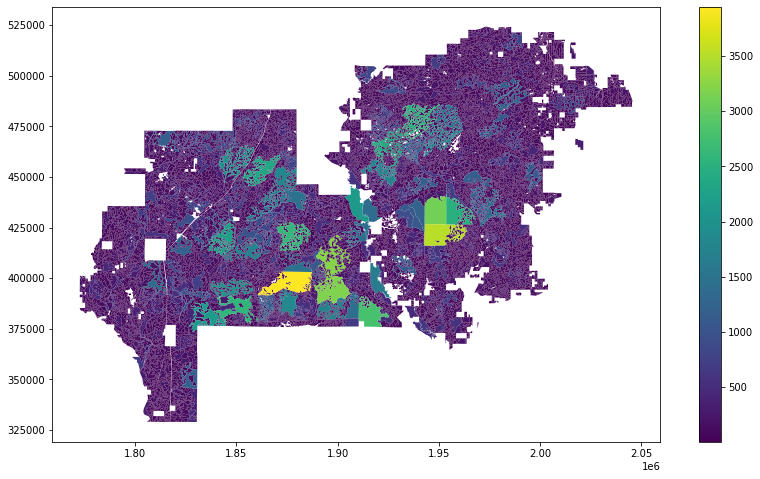

In [5]:
print("Field Names = " + str(anf_df.field_names))
print("Projectoin Code = " + str(anf_df.crs))
print("ANF Stand Acres")
p1=anf_df.data.compute().plot(column='ACRES',legend=True,figsize=(14,8))
p1

## Create an interactive map and explore

In [7]:
import folium
#add our layers to the map
p1=anf_df.geometry.representative_point().compute().explore(color="red",name="Centroid")
p2=anf_df.geometry.compute().explore(m=p1,color="blue",name="ANF Stands")

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p2)

#add layer controls to the map
folium.LayerControl().add_to(p2)

#show the interactive map
p2

## Create a series of functions that quatify shape complexity and that can be used to create predictor variables
- _redistribute_vertices
- calc_metrics
- calc_all 
- stat_type class

In [8]:
# Metrics
from shapely.geometry import MultiPoint, LineString
import numpy as np

def _redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

def calc_metrics(gdf,mtype=8,smp=30):
    '''CalcMetric will calculate various spatial shape metrics for a given polygon
    gdf: geodataframe with polygon geometry
    mtype: statistic type (mean, var, sd, min, max, area, perimeter, perimeter to area, fractal, all) [0,1,2,3,4,5,6,7,8]
    
    returns: list of values for each row. If all is specified for mtype a list of shape metric value lists will be returned
    [[mean], [var], [sd], [min], [max], [area], [perimeter], [perimeter to area], [fractal]]
    '''
    geo=gdf.geometry
    outlst = []
    if(mtype==0):
        outlst=_calc_all(geo)[0]
    elif(mtype==1):
        outlst=_calc_all(geo)[1]
    elif(mtype==2):
        outlst=_cal_all(geo)[2]
    elif(mtype==3):
        outlst=_calc_all(geo)[3]
    elif(mtype==4):
        outlst=_calc_all(geo)[4]
    elif(mtype==5):
        outlst=_calc_all(geo)[5]
    elif(mtype==6):
        outlst=_calc_all(geo)[6]
    elif(mtype==7):
        outlst=_calc_all(geo)[7]
    elif(mtype==7):
        outlst=_calc_all(geo)[8]
    else:
        outlst=_calc_all(geo,smp)
    
    return outlst
        
def _calc_all(geo,smp=30):
    outlst=[[],[],[],[],[],[],[],[],[]]
    for g in geo.geometry:
        c_p = g.representative_point()
        lns=LineString(g.exterior.coords)
        if(smp!=None):
            lns=_redistribute_vertices(lns, smp)
        bnd_pnt = MultiPoint(lns.coords)
        min= np.inf
        max=0
        s=0
        ss=0
        n=0
        
        for p in bnd_pnt.geoms:
            d=c_p.distance(p)
            if(d>max):max=d
            if(d<min):min=d
            s+=d
            ss+=d*d
            n+=1
        outlst[0].append(s/n)
        var=(ss - ((s*s)/n))/(n-1)
        outlst[1].append(var)
        outlst[2].append(np.sqrt(var))
        outlst[3].append(min)
        outlst[4].append(max)
        a=g.area
        p=g.length
        outlst[5].append(a)
        outlst[6].append(p)
        outlst[7].append(p/a)
        outlst[8].append(np.log(a)/(np.log(p)+np.log(0.25)))
    
    return outlst

class stat_type():
    '''shape metrices'''
    MEAN = 0
    VAR = 1
    SD = 2
    MIN = 3
    MAX = 4
    AREA = 5
    PERIMETER = 6
    PA = 7
    FRACTAL= 8
    ALL = 9
 

## Look at the centroid, polygon boundary, vertices, and shape metrics for the first geometry

[[1762.951339347456], [568441.1953826452], [753.9503931842236], [296.7277106296634], [3082.4441472745025], [5350720.965539542], [22916.957053311085], [0.004282966202293871], [1.7903775171296505]]


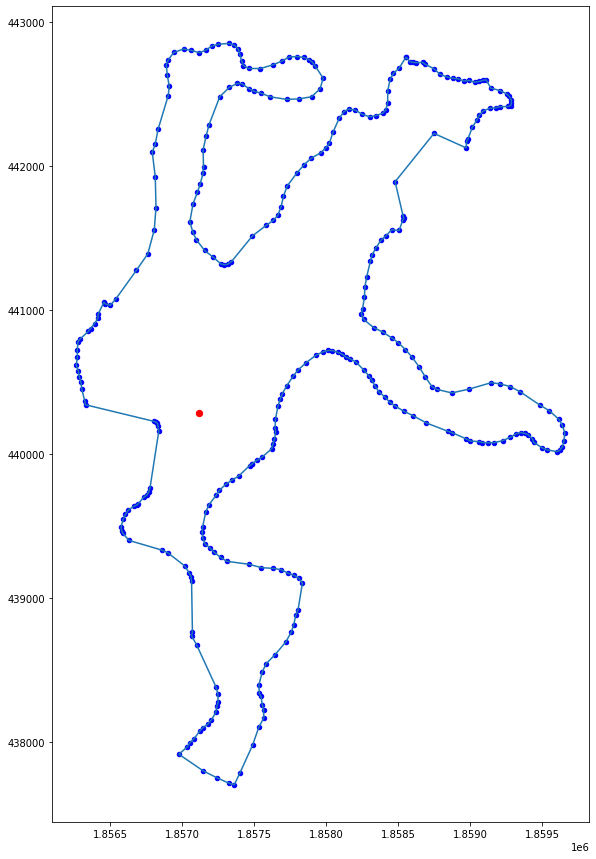

In [9]:
from shapely.geometry import MultiPoint, MultiLineString, LineString, Point
import numpy as np, matplotlib.pyplot as plt
geo=anf_df.geometry[0].compute()
cp=geo.representative_point()
bndy=geo.boundary
p1=bndy.plot(figsize=(10,15))
p2=cp.plot(ax=p1,color='red',markersize=40)
p3=gpd.GeoSeries(Point(pnt[0],pnt[1]) for pnt in list(bndy[0].coords)).plot(ax=p2,color='blue',markersize=20)
print(_calc_all(geo,None))


## Look at centroid, polygon boundary, vertices, and shape metrics for the first geometry densified

[[1726.0365498654057], [498159.8014839851], [705.8043648802302], [304.4571653817575], [3082.3499837002355], [5350720.965539542], [22916.957053311085], [0.004282966202293871], [1.7903775171296505]]


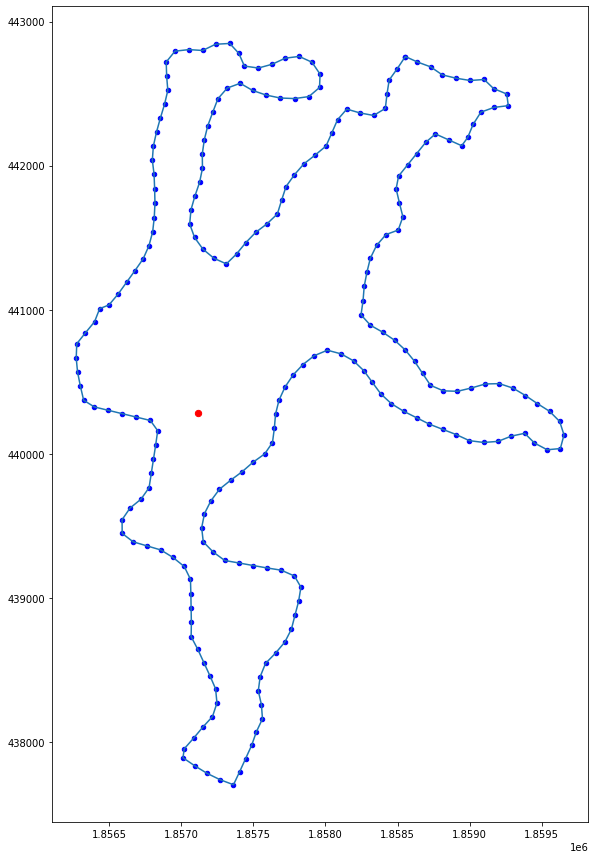

In [10]:

nbndy=gpd.GeoSeries(_redistribute_vertices(LineString(bndy[0]),100))
p1=nbndy.plot(figsize=(10,15))
p2=cp.plot(ax=p1,color='red',markersize=40)
p3=gpd.GeoSeries(Point(pnt[0],pnt[1]) for pnt in list(nbndy[0].coords)).plot(ax=p2,color='blue',markersize=20)
print(_calc_all(geo,100))

## Calculate shape metrics for all geometries densified 100 m 
- Shape metrics calculated: mean, var, sd, min, max, area, peremiter,peremiter to area, fractal. 
- This will take a little time to process the data (about 5 minutes).

In [11]:
vls=calc_metrics(anf_df,mtype=stat_type.ALL,smp=30)
#should be a length of 9 (9 lists)
print(len(vls))

9


## Add the shape metrics to the dask geopandas dataframe and create a new Vector object
- The output from calc_metrics function returns a list of shape metric lists. 
- Lists correspond to mean (0), var (1), sd (2), min (3), max (4), area (5), perimeter (6), perimeter to area (7), and fractal (8) values

In [12]:
import pandas as pd
anf_df2=Vector(anf_df.data.assign(Mean=pd.Series(vls[0]),
                   Var=pd.Series(vls[1]),
                   Sd=pd.Series(vls[2]),
                   Min=pd.Series(vls[3]),
                   Max=pd.Series(vls[4]),
                   Area=pd.Series(vls[5]),
                   Pr=pd.Series(vls[6]),
                   Pa=pd.Series(vls[7]),
                   Fractal=pd.Series(vls[8])
                                 )
              )
anf_df2.data

,POLY_ID,ACRES,EV_CODE,Forest_T_1,Class,geometry,Mean,Var,Sd,Min,Max,Area,Pr,Pa,Fractal
npartitions=1,,,,,,,,,,,,,,,
0,int64,float64,object,object,object,geometry,float64,float64,float64,float64,float64,float64,float64,float64,float64
9815,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Split the data into random subsets used to train a model, test a model, and finally validate a model
- train sample size 5%
- test sample size 5%
- validation sample size 90%

In [14]:
sub=anf_df2.data.sample(frac=0.10,random_state=12345)
train=sub.sample(frac=0.5,random_state=12345)
tid=train['POLY_ID']
sid=sub['POLY_ID']
check=sid.ne(tid)
test=sub[check]
did=anf_df2.data['POLY_ID']
check2=did.ne(sid)
val=anf_df2.data[check2]

## Create random forest functions using scikit learn
- random forest model
- store model
- open model
- predict new values

In [15]:
from sklearn.ensemble import RandomForestClassifier
import pickle
def rand_forest(train,resp,pred,trees=50,criterion='gini',n_jobs=-1,max_samples=0.66):
    '''This function is used to create a random forest model. 
    vector: vector object
    resp: response column name (string)
    pred: list of predictor varible column names (strings)
    trees: number of random forest trees
    criterion: gini or entropy
    n_jobs: number of processors to use when estimating the model (-1 = all)
    max_samples: proportion of input data to use to train each tree. 1-max_samples is used to evaluate each tree.
    
    returns a sklearn random forest model
    '''
    X = train[pred].to_dask_array().compute()
    fct=train[resp].compute().factorize()
    y = fct[0]
    mdl = RandomForestClassifier(n_estimators=trees,oob_score=True,random_state=0,criterion=criterion,n_jobs=n_jobs,max_samples=max_samples)
    mdl.fit(X,y)
    return [fct,mdl]   

def store_model(mdl,path):
    '''This function will serialize a model to disk
    inputs include a model (mdl) and a file path with extension (path)
   
    mdl: sklearn mdl
    path: the location to store the model
    '''
    s = pickle.dump(mdl,open(path, 'wb'))

def open_model(path):
    '''This function will read a serialized model (path) back into memory
    returns model.
    
    path: the path to the stored model
    
    returns: scklearn model
    '''
    mdl = pickle.load(open(path, 'rb'))
    return mdl
  
def predict_new_values(mdl, dgdf, pred):
    '''This function will predict the probability of each class for a new record from a random forest model (mdl) and predictor (pred) values 
    mdl: sklearn random forest model
    df: dataframe
    pred: predictor values [[0,0,0,0...]]
    returns list of class and probabilities, most likely class is located at [0]'''
    x=dgdf[pred].to_dask_array().compute()
    prb = mdl.predict_proba(x)
    return prb



## Create Random forest model using our training dataset
- create the model (mdl)
- store the model (anf_veg_class.mdl)
- open the model (mdl2)
- look at OOBs (mdl, mdl2)

In [16]:
pred=['Mean','Sd','Min','Max','Area','Pr','Pa','Fractal']
resp='Class'
fct,mdl=rand_forest(train,resp,pred)
mdl_path='anf_veg_class.mdl'
store_model(mdl,mdl_path)
mdl2=open_model(mdl_path)
print('OOB from mdl = ' + str(mdl.oob_score_))
print('OOB from mdl2 = ' + str(mdl2.oob_score_))

OOB from mdl = 0.790224032586558
OOB from mdl2 = 0.790224032586558


## Predict classs probabilities and calculate accuracy for the following datasets:
- test
- val
- anf_df.data 

In [17]:
def get_estimation_dataframe(mdl,df,pred,clm_names):
    vls=predict_new_values(mdl,df,pred)
    odf=gpd.GeoDataFrame(data=vls)
    odf.columns = clm_names
    odf['MLC']=odf.idxmax(axis=1)
    odf['Class']=df['Class'].compute().values
    odf['Correct']=odf['MLC'].eq(odf['Class'])
    print('Accuracy = ' + str(odf['Correct'].sum()/odf.shape[0]))
    return odf

est_t=get_estimation_dataframe(mdl,test,pred,fct[1])
est_v=get_estimation_dataframe(mdl,val,pred,fct[1])
est_all=get_estimation_dataframe(mdl,anf_df2.data,pred,fct[1])

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


Accuracy = 0.7841140529531568
Accuracy = 0.7979397781299524
Accuracy = 0.8048084759576202


## Graph importance values for predictor variablesPODs presentation to NISC/WFLC task team

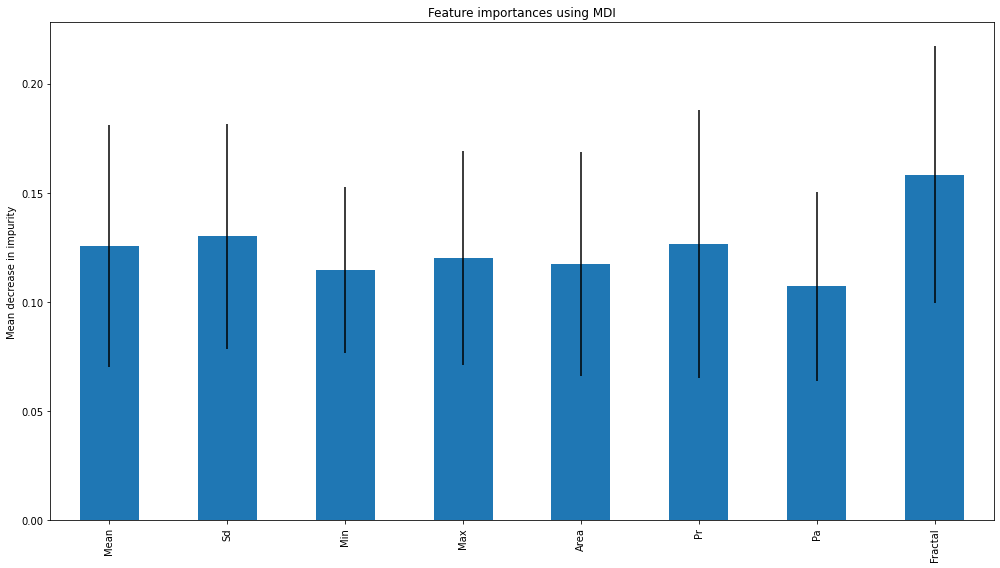

In [18]:
imp=mdl.feature_importances_
v_imp = pd.Series(imp, index=pred)
fig, ax = plt.subplots(figsize=(14,8))
std = np.std([tree.feature_importances_ for tree in mdl.estimators_], axis=0)
v_imp.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Graph accuracy by class

Overall Accuracy = 80.48

col_0          Hardwood  Hardwood Pine  Non Forest  Pine  Pine Hardwood
row_0                                                                  
Hardwood            414              1           0  1221              0
Hardwood Pine        26              4           0   161              0
Non Forest            6              0           1     9              0
Pine                247              2           0  7476              0
Pine Hardwood        42              1           0   200              5



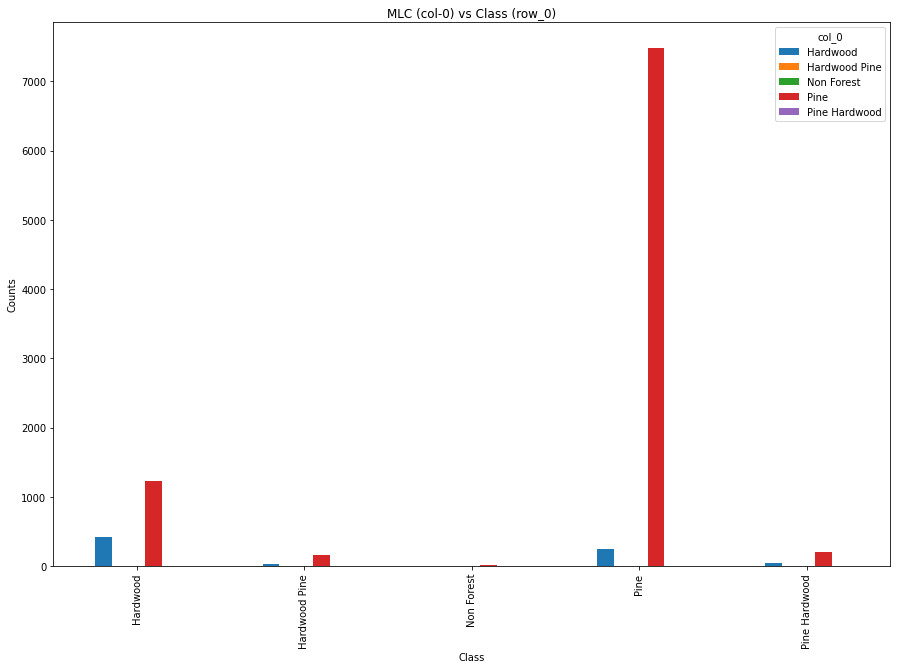

In [19]:
#Class by Mapped Values
bvl=est_all['Correct'].astype('int').values
print("Overall Accuracy = " + str(np.round(bvl.sum()/len(bvl)*100,decimals=2))+ '\n')
mvl=est_all['MLC'].values
cvl=est_all['Class'].values
xtbl=pd.crosstab(cvl,mvl,dropna=False)
print(xtbl)
print()
xtbl.plot(kind='bar',title="MLC (col-0) vs Class (row_0)",figsize=(15,10),xlabel='Class',ylabel='Counts')

## Merge est_all with anf_df2 and plot Pine class probabilites

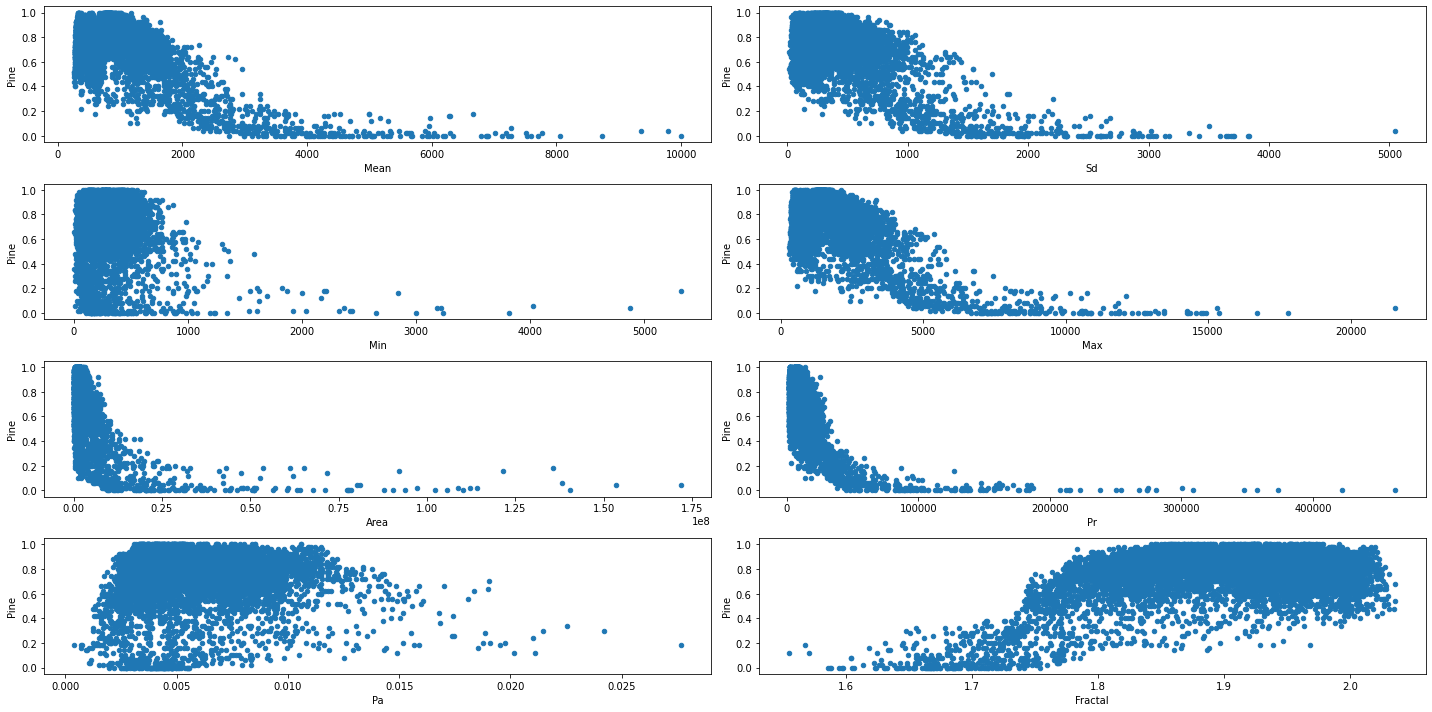

In [20]:
anf_df3=anf_df2.data.merge(est_all[['Pine','Hardwood','Pine Hardwood','Hardwood Pine','Non Forest','MLC']]).compute()
f, axes = plt.subplots(figsize=(20, 10), ncols=2, nrows=4,tight_layout=True)
cnt=0
for x in pred:
    anf_df3.plot(x=x,y='Pine',kind='scatter',ax=axes[cnt//2][cnt%2],)
    cnt+=1


## Explore MLC

In [21]:
from folium import plugins
p1=anf_df3.explore(color="red",name="MLC",column='MLC',style_kwds={'opacity':0.7})

#add ESRI's tiled imagery to potential base maps
folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Imagery',
        overlay = False,
        control = True
       ).add_to(p1)

#add layer controls to the map
folium.LayerControl().add_to(p1)

#add full screen to map
plugins.Fullscreen().add_to(p1)

#show the interactive map
p1

## Save to HTML file

In [22]:
p1.save('mlc.html')